In [56]:
import os
import json
from web3 import Web3, HTTPProvider

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from utils.eth_blocks_utils import get_timestamp_for_block

In [30]:
ALCHEMY_API_KEY = os.environ['ALCHEMY_API_KEY']
web3 = Web3(HTTPProvider(f"https://eth-mainnet.alchemyapi.io/v2/{ALCHEMY_API_KEY}"))

In [31]:
pool_addr = "0x5a6A4D54456819380173272A5E8E9B9904BdF41B"

In [32]:
with open("./mim-3pool.json", 'r') as f:
    abi = json.load(f)
mim_3pool = web3.eth.contract(address=pool_addr, abi=abi)
mim_3pool

In [33]:
current_block = web3.eth.get_block_number()
current_block

13673437

In [34]:
genesis_block = 12557139

In [35]:
mim3pool_add_liquidity_filter = mim_3pool.events.AddLiquidity.createFilter(
    fromBlock=genesis_block,
    toBlock=current_block
)
mim3pool_remove_liquidity_filter = mim_3pool.events.RemoveLiquidity.createFilter(
    fromBlock=genesis_block,
    toBlock=current_block
)
mim3pool_remove_liquidity_one_filter = mim_3pool.events.RemoveLiquidityOne.createFilter(
    fromBlock=genesis_block,
    toBlock=current_block
)
mim3pool_remove_liquidity_imbalance_filter = mim_3pool.events.RemoveLiquidityImbalance.createFilter(
    fromBlock=genesis_block,
    toBlock=current_block
)


In [36]:
add_liquidity_events = mim3pool_add_liquidity_filter.get_all_entries()
add_liquidity_event_blocks = [event['blockNumber'] for event in add_liquidity_events]

In [37]:
remove_liquidity_events = (
        mim3pool_add_liquidity_filter.get_all_entries() +
        mim3pool_remove_liquidity_one_filter.get_all_entries() +
        mim3pool_remove_liquidity_imbalance_filter.get_all_entries()
)
remove_liquidity_event_blocks = [event['blockNumber'] for event in remove_liquidity_events]

In [40]:
len(remove_liquidity_event_blocks)

7949

In [43]:
block_steps = list(range(genesis_block, current_block, int(0.25 * round(current_block - genesis_block))))
block_ranges = list(zip(block_steps, block_steps[1:]))
block_ranges

[(12557139, 12836213),
 (12836213, 13115287),
 (13115287, 13394361),
 (13394361, 13673435)]

In [47]:
swap_event_blocks = []
for (block_start, block_end) in block_ranges:

    mim3pool_token_exchange_filter = mim_3pool.events.TokenExchange.createFilter(
        fromBlock=block_start,
        toBlock=block_end
    )
    mim3pool_token_exchange_underlying_filter = mim_3pool.events.TokenExchangeUnderlying.createFilter(
        fromBlock=block_start,
        toBlock=block_end
    )
    swap_events = (
            mim3pool_token_exchange_filter.get_all_entries() +
            mim3pool_token_exchange_underlying_filter.get_all_entries()
    )
    swap_event_blocks.extend([event['blockNumber'] for event in swap_events])

plots:

In [52]:
df_swap_event_blocks = pd.DataFrame(data=swap_event_blocks, columns=['block_number'])
df_swap_event_blocks['num_swaps'] = 1
df_add_liquidity_blocks = pd.DataFrame(data=add_liquidity_event_blocks, columns=['block_number'])
df_add_liquidity_blocks['num_swaps'] = 1
df_remove_liquidity_blocks = pd.DataFrame(data=remove_liquidity_event_blocks, columns=['block_number'])
df_remove_liquidity_blocks['num_swaps'] = 1

In [81]:
bins = list(range(genesis_block, current_block, 50000))

In [103]:
def bin_txes(df, bins, column_name):
    df_binned = pd.cut(df['block_number'], bins=bins).value_counts()
    df_binned = df_binned.reset_index()
    df_binned['block_end'] = [a.right for a in df_binned['index']]
    df_binned.drop(columns=['index'], inplace=True)
    df_binned = df_binned.rename(columns={"block_number": column_name})
    df_binned.set_index("block_end", inplace=True)
    df_binned.sort_index(ascending=True, inplace=True)
    return df_binned

In [104]:
df_binned_swaps = bin_txes(df_swap_event_blocks, bins, 'num_swap_txes')
df_binned_add_liq = bin_txes(df_add_liquidity_blocks, bins, 'num_add_txes')
df_binned_remove_liq = bin_txes(df_remove_liquidity_blocks, bins, 'num_remove_txes')

In [106]:
df_all = pd.concat([df_binned_add_liq, df_binned_remove_liq, df_binned_swaps], axis=1)

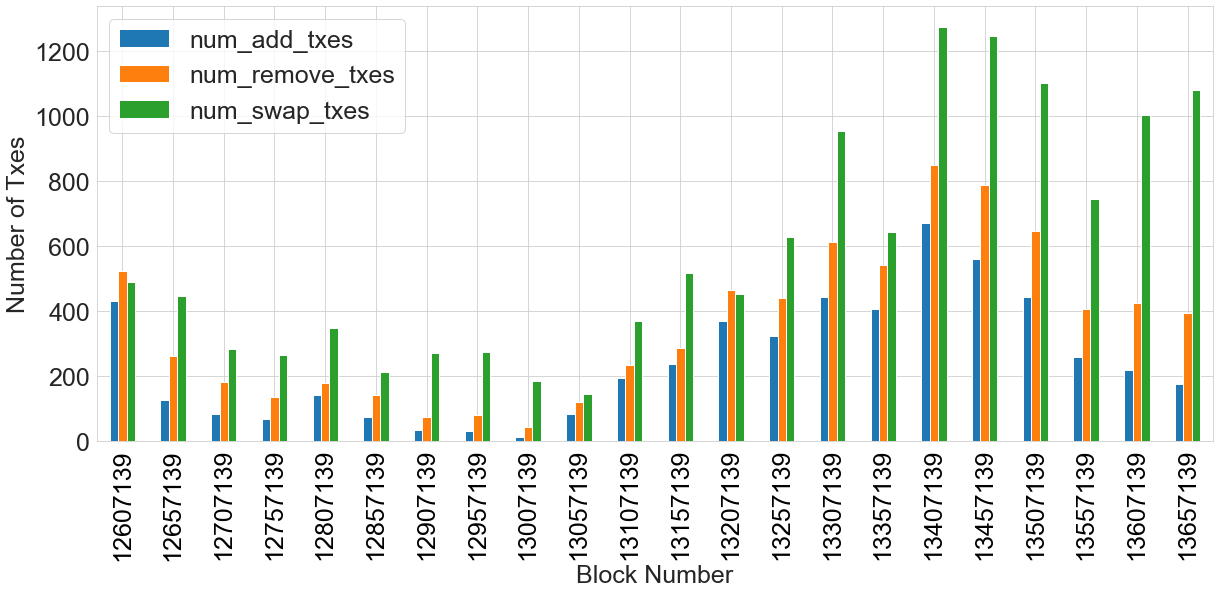

In [113]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

df_all.plot(
    ax=ax,
    kind='bar',
    stacked=False
)

ax.set_xlabel("Block Number", fontsize=25)
ax.set_ylabel("Number of Txes", fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.tick_params(axis='x', which='major', colors='black')
ax.legend(fontsize=25)

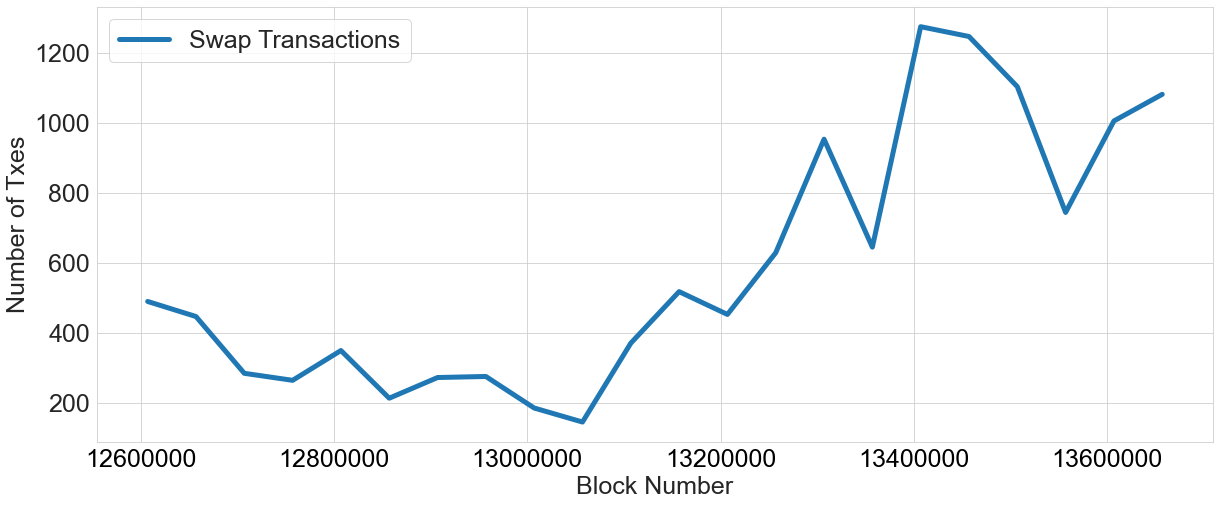

In [112]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

ax.plot(df_all.index, df_all.num_swap_txes, lw=5, label='Swap Transactions')

ax.set_xlabel("Block Number", fontsize=25)
ax.set_ylabel("Number of Txes", fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.tick_params(axis='x', which='major', colors='black')
ax.legend(fontsize=25)
ax.xaxis.get_major_formatter().set_scientific(False)
ax.xaxis.get_major_formatter().set_useOffset(False)

Volume:

In [123]:
swap_event_tokens_sold = []
swap_event_tokens_bought = []
swap_event_tokens_sold_id = []
swap_event_tokens_bought_id = []

for (block_start, block_end) in block_ranges:

    mim3pool_token_exchange_filter = mim_3pool.events.TokenExchange.createFilter(
        fromBlock=block_start,
        toBlock=block_end
    )
    mim3pool_token_exchange_underlying_filter = mim_3pool.events.TokenExchangeUnderlying.createFilter(
        fromBlock=block_start,
        toBlock=block_end
    )
    swap_events = (
            mim3pool_token_exchange_filter.get_all_entries() +
            mim3pool_token_exchange_underlying_filter.get_all_entries()
    )
    swap_event_tokens_sold.extend([event['args']['tokens_sold'] for event in swap_events])
    swap_event_tokens_sold_id.extend([event['args']['sold_id'] for event in swap_events])
    swap_event_tokens_bought.extend([event['args']['tokens_bought'] for event in swap_events])
    swap_event_tokens_bought_id.extend([event['args']['bought_id'] for event in swap_events])


In [124]:
df_swaps = pd.DataFrame(data=swap_event_blocks, columns=['block_number'])
df_swaps['num_swaps'] = 1
df_swaps['tokens_sold'] = swap_event_tokens_sold
df_swaps['tokens_bought'] = swap_event_tokens_bought
df_swaps['sold_id'] = swap_event_tokens_sold_id
df_swaps['bought_id'] = swap_event_tokens_bought_id
df_swaps

,block_number,num_swaps,tokens_sold,tokens_bought,sold_id,bought_id
0,12598467,1,4750020928521085389255,4706316047564471323642,0,1
1,12613004,1,1973012688257204512713015,2059619396703113073238132,1,0
2,12645061,1,7515098329229577670970,7246946553668064971847,0,1
3,12691178,1,2859676766186807487238,2791288768175300368457,0,1
4,12730677,1,1410262590663732967478,1377850717429667035127,0,1
...,...,...,...,...,...,...
13212,13673108,1,53376977043081463754763,53349276051169751023679,0,1
13213,13673202,1,1583405908688499999999,1581959576,0,3
13214,13673250,1,1185000000000619157635616,1184430441874,0,2
13215,13673323,1,2077008566927,2076517359340105330218825,3,0


In [130]:
df_swaps['tokens_sold_float'] = (
        (df_swaps['tokens_sold'].where(df_swaps['sold_id'].isin([2, 3])) * 1e-6).fillna(0) +
        (df_swaps['tokens_sold'].where(df_swaps['sold_id'].isin([0, 1])) * 1e-18).fillna(0)
)
df_swaps['tokens_bought_float'] = (
        (df_swaps['tokens_bought'].where(df_swaps['bought_id'].isin([2, 3])) * 1e-6).fillna(0) +
        (df_swaps['tokens_bought'].where(df_swaps['bought_id'].isin([0, 1])) * 1e-18).fillna(0)
)
df_swaps

,block_number,num_swaps,tokens_sold,tokens_bought,sold_id,bought_id,tokens_sold_float,tokens_bought_float
0,12598467,1,4750020928521085389255,4706316047564471323642,0,1,4.750021e+03,4.706316e+03
1,12613004,1,1973012688257204512713015,2059619396703113073238132,1,0,1.973013e+06,2.059619e+06
2,12645061,1,7515098329229577670970,7246946553668064971847,0,1,7.515098e+03,7.246947e+03
3,12691178,1,2859676766186807487238,2791288768175300368457,0,1,2.859677e+03,2.791289e+03
4,12730677,1,1410262590663732967478,1377850717429667035127,0,1,1.410263e+03,1.377851e+03
...,...,...,...,...,...,...,...,...
13212,13673108,1,53376977043081463754763,53349276051169751023679,0,1,5.337698e+04,5.334928e+04
13213,13673202,1,1583405908688499999999,1581959576,0,3,1.583406e+03,1.581960e+03
13214,13673250,1,1185000000000619157635616,1184430441874,0,2,1.185000e+06,1.184430e+06
13215,13673323,1,2077008566927,2076517359340105330218825,3,0,2.077009e+06,2.076517e+06


In [135]:
pd.cut(df_swaps['block_number'], bins=bins).agg({'tokens_sold_float':'sum','tokens_bought_float':'sum'})

TypeError: 'Categorical' does not implement reduction 'sum'

In [129]:
df_binned_swaps = pd.cut(df_swaps['block_number'], bins=bins).sum()
df_binned = df_binned.reset_index()
df_binned['block_end'] = [a.right for a in df_binned['index']]
df_binned.drop(columns=['index'], inplace=True)
df_binned = df_binned.rename(columns={"block_number": column_name})
df_binned.set_index("block_end", inplace=True)
df_binned.sort_index(ascending=True, inplace=True)
return df_binned

0        4.750021e+03
1        1.973013e+06
2        7.515098e+03
3        2.859677e+03
4        1.410263e+03
             ...     
13212    5.337698e+04
13213    1.583406e+03
13214    1.185000e+06
13215    2.077009e+06
13216    1.429073e+07
Name: tokens_sold, Length: 13217, dtype: float64